# Compare decay calculation results of radioactivedecay and Radiological Toolbox
This notebook compares decay calculation results between the Python package [radioactivedecay](https://pypi.org/project/radioactivedecay/) and ORNL's [Radiological Toolbox version 3.0.0](https://www.ornl.gov/crpk/software).

Fifty radionuclides were randomly selected from the ICRP 107 dataset. A decay calculation was performed for each radionuclide (*A*<sub>0</sub> = 1 Bq) using a randomly selected decay time in the range [10<sup>-3</sup> *t*<sub>1/2</sub>, 10<sup>3</sup> *t*<sub>1/2</sub>), where *t*<sub>1/2</sub> is its half-life.

First load the necessary modules. 

In [1]:
import radioactivedecay as rd
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print("Using radioactivedecay version:", rd.__version__)

Using radioactivedecay version: 0.0.8


### Load results from Radiological Toolbox

Define a function to read in a CSV file with decay calculation results from Radiological Toolbox for one radionuclide.

In [2]:
def read_inventory(radionuclide):
    """Read in the decay time, its unit and the decayed inventory of radionuclide."""

    with open(radionuclide + ".csv") as fin:
        lines = fin.readlines()
        decay_time = float(lines[0].split()[5])
        decay_time_unit = lines[0].split()[6][0]
        inv = {}
        
        for i in range(2, len(lines)):
            line = lines[i].split(",")
            nuclide = line[0].strip()
            inv[nuclide] = float(line[1])

        return decay_time, decay_time_unit, inv

Open the folder containing the Radiological Toolbox decay calculation results files and add the radionuclides to a list.

In [3]:
rootdir = os.getcwd().replace("\\", "/")
os.chdir(rootdir + "/radiological_toolbox_3.0.0_results")
nuclides = [nuclide[:-4] for nuclide in glob.glob("*.csv")]

### Compare results between radioactivedecay and Radiological Toolbox

For each radionuclide compare the decay calculation results from radioactivedecay and Radiological Toolbox. First we check that the inventories contain the same radionuclides, then we compare the activity of each radionuclide. Note that Radiological Toolbox uses single precision arithmetic for its calculations and reports activities to four significant figures. Therefore for the comparisons we cast the double precision activities reported by radioactivedecay to single precision floats then round to four significant figures.

We use the absolute difference between activities and the relative difference to the Radiological Toolbox activity as the comparison metrics.

In [4]:
def round_4sf(num):
    """Round a float to four significant figures."""

    return float(f'{float(f"{num:.4g}"):g}')

rows = []

for nuclide in nuclides:
    decay_time, decay_time_unit, rt_inv = read_inventory(nuclide)
    rd_inv = rd.Inventory({nuclide: 1.0}).decay(decay_time, decay_time_unit).contents
    if set(rd_inv.keys()) != set(rt_inv.keys()):
        print("Warning: contents of inventories different following decay of:",
              nuclide, set(rd_inv.keys()), set(rt_inv.keys()))

    for nuc, rt_act in rt_inv.items():
        rd_act = round_4sf(np.float32(rd_inv[nuc]))
        if rt_act == 0.0:
            if rd_act == 0.0:
                abs_err = 0.0
                rel_err = 0.0
            else:
                abs_err = abs(rd_act)
                rel_err = np.inf
        else:
            abs_err = abs(rt_act-rd_act)
            rel_err = abs_err/abs(rt_act)

        rows.append({
            'parent': nuclide,
            'decay_time': decay_time,
            'decay_time_unit': decay_time_unit,
            'nuclide': nuc,
            'rt_activity': rt_act,
            'rd_activity': rd_act,
            'abs_err': abs_err,
            'rel_err': rel_err,
        })

df = pd.DataFrame(rows)

print("Total activities compared:", len(rows))
print("Identical activities:", len(df[df.rt_activity == df.rd_activity]))
print("Relative difference of activities less than 1%:", len(df[(df.rel_err < 0.01) & (df.rel_err > 0.0)]))
print("Relative difference greater than or equal to 1%:", len(df[df.rel_err >= 0.01]))

Total activities compared: 237
Identical activities: 134
Relative difference of activities less than 1%: 24
Relative difference greater than or equal to 1%: 79


In 134 cases (134/237 ~ 57% of cases) the activities calculated by Radiological Toolbox and radioactivedecay are identical (to four significant figures).

### Discrepancies originating with parent radionuclide of decay chain

We analyse the 103 cases with discrepancies by first considering if discrepancies occur for the parent radionuclide of the decay chain or not. Discrepancies that occur at the chain parent are:

In [5]:
parents_df = df[(df.parent == df.nuclide) & (df.abs_err > 0.0)].copy()
parents_df

,parent,decay_time,decay_time_unit,nuclide,rt_activity,rd_activity,abs_err,rel_err
113,Fr-219,0.012643,m,Fr-219,3.540000e-12,3.820000e-12,2.800000e-13,0.079096
136,Nb-99,23.704052,m,Nb-99,2.371000e-29,2.867000e-29,4.960000e-30,0.209194
156,O-14,47.493098,m,O-14,6.540000e-13,7.091000e-13,5.510000e-14,0.084251
193,Pt-189,1466.011040,h,Pt-189,2.517000e-41,2.516000e-41,1.000000e-44,0.000397
196,Ra-220,0.000087,m,Ra-220,8.174000e-01,8.178000e-01,4.000000e-04,0.000489
220,Sc-42m,0.568096,m,Sc-42m,6.824000e-01,6.831000e-01,7.000000e-04,0.001026
232,Xe-127m,11.904544,m,Xe-127m,7.653000e-04,7.813000e-04,1.600000e-05,0.020907
235,Zr-89m,296.489476,m,Zr-89m,3.550000e-22,3.551000e-22,1.000000e-25,0.000282


The discrepancies for Pt-189 and Zr-89m are in the final significant digit of the activity after a very long decay period. These discrepancies can plausibly be explained by simple rounding or numerical precision errors.

For the other radionuclides (Fr-219, Nb-99, O-14, Ra-220, Sc-42m and Xe-127m), Radiological Toolbox shows some computational instabilities, e.g. decaying for one, two, three half-lives etc. gives results that differ from 0.5 Bq, 0.25 Bq, 0.125 Bq, respectively. This may be related to truncations and round off error propagations that are occurring within its calculations, perhaps associated with its use of single precision arithmetic. Checks were performed using an Excel spreadsheet for these radionuclides, and these showed the results reported by radioactivedecay are in fact correct.

### Other discrepancies

Now we focus on the discrepancies that occur below the parent radionuclide in the decay chains. The chains affected are:

In [6]:
parent_discrepancies = df[(df.parent == df.nuclide) & (df.abs_err > 0.0)].parent
df['parent_discrepancy'] = df['parent'].isin(parent_discrepancies)
df[(df.parent_discrepancy == False) & (df.abs_err > 0.0)].parent.unique()

array(['Am-238', 'Am-246m', 'Au-187', 'Bk-245', 'Cf-254', 'Cs-121m',
       'Pa-234'], dtype=object)

Dealing with these radionuclides individually, we find that the discrepancies for Au-187 and Cs-121m are minor (occurring in the last significant digit of the activity only) and are plausibly explained by numerical precision issues in Radiological Toolbox.

In [7]:
last_digit_df = df[(df.parent.isin(['Au-187', 'Cs-121m'])) & (df.rel_err > 0.0)].copy()
last_digit_df

,parent,decay_time,decay_time_unit,nuclide,rt_activity,rd_activity,abs_err,rel_err,parent_discrepancy
49,Au-187,0.023479,m,Re-183,5.114000e-21,5.112000e-21,2.000000e-24,0.000391,False
107,Cs-121m,0.003706,m,Cs-121,1.693000e-04,1.689000e-04,4.000000e-07,0.002363,False
110,Cs-121m,0.003706,m,Te-121m,5.930000e-21,5.933000e-21,3.000000e-24,0.000506,False
111,Cs-121m,0.003706,m,Te-121,1.660000e-17,1.663000e-17,3.000000e-20,0.001807,False


We note that the remaining radionuclides (Am-238, Am-246m, Bk-245, Cf-254 and Pa-234) are all relatively short lived radionuclides with decay chains containing a significantly longer half-life progeny. For example the Am-238 (*t*<sub>1/2</sub> = 98 mins) decay chain passes through U-234 (*t*<sub>1/2</sub> = 245500 years), and the Cf-254 (*t*<sub>1/2</sub> = 60.5 days) decay chain passes through U-238 (*t*<sub>1/2</sub> = 4.468E+9 years). The large disparity between the half-lives of the parent and progeny radionuclides in these decay chains causes numerical precision issues both for Radiological Toolbox and radioactivedecay. Note that all the discrepancies occur in the activities of the radionuclides below the long half-life progeny in the decay chain (see following tables).

See also this article on PyNE's [decay function](https://pyne.io/theorymanual/decay.html) about decay chains passing through almost stable radionuclides.

In [8]:
long_hl_progeny_df = df[(df.parent.isin(['Am-238', 'Am-246m', 'Bk-245', 'Cf-254', 'Pa-234'])) 
                        & (df.rel_err > 0.0)].copy()
long_hl_progeny_df[long_hl_progeny_df.parent.isin(['Am-238', 'Am-246m', 'Bk-245'])]

,parent,decay_time,decay_time_unit,nuclide,rt_activity,rd_activity,abs_err,rel_err,parent_discrepancy
5,Am-238,8435.569952,m,Th-230,6.899000e-21,6.898000e-21,1.000000e-24,1.449485e-04,False
6,Am-238,8435.569952,m,Ra-226,9.190000e-29,-2.210000e-26,2.219190e-26,2.414788e+02,False
7,Am-238,8435.569952,m,Rn-222,2.031000e-29,1.850000e-26,1.847969e-26,9.098813e+02,False
8,Am-238,8435.569952,m,Po-218,2.031000e-29,-1.482000e-25,1.482203e-25,7.297898e+03,False
9,Am-238,8435.569952,m,Pb-214,1.992000e-29,-1.076000e-25,1.076199e-25,5.402606e+03,False
10,Am-238,8435.569952,m,At-218,4.044000e-33,3.683000e-29,3.682596e-29,9.106319e+03,False
11,Am-238,8435.569952,m,Bi-214,1.992000e-29,2.720000e-25,2.719801e-25,1.365362e+04,False
12,Am-238,8435.569952,m,Rn-218,3.997000e-36,4.293000e-32,4.292600e-32,1.073956e+04,False
13,Am-238,8435.569952,m,Po-214,1.953000e-29,1.656000e-26,1.654047e-26,8.469263e+02,False
14,Am-238,8435.569952,m,Tl-210,4.142000e-33,1.572000e-29,1.571586e-29,3.794268e+03,False


In [9]:
long_hl_progeny_df[long_hl_progeny_df.parent.isin(['Cf-254', 'Pa-234'])]

,parent,decay_time,decay_time_unit,nuclide,rt_activity,rd_activity,abs_err,rel_err,parent_discrepancy
86,Cf-254,1448.174376,d,U-238,4.001000e-27,4.003000e-27,2.000000e-30,4.998750e-04,False
87,Cf-254,1448.174376,d,Th-234,3.706000e-27,3.703000e-27,3.000000e-30,8.094981e-04,False
88,Cf-254,1448.174376,d,Pa-234m,3.703000e-27,3.707000e-27,4.000000e-30,1.080205e-03,False
89,Cf-254,1448.174376,d,Pa-234,5.929000e-30,5.916000e-30,1.300000e-32,2.192613e-03,False
90,Cf-254,1448.174376,d,U-234,0.000000e+00,-8.930000e-30,8.930000e-30,inf,False
91,Cf-254,1448.174376,d,Th-230,2.465000e-32,-2.636000e-29,2.638465e-29,1.070371e+03,False
92,Cf-254,1448.174376,d,Ra-226,0.000000e+00,-1.413000e-29,1.413000e-29,inf,False
93,Cf-254,1448.174376,d,Rn-222,0.000000e+00,1.401000e-29,1.401000e-29,inf,False
94,Cf-254,1448.174376,d,Po-218,0.000000e+00,-1.643000e-29,1.643000e-29,inf,False
95,Cf-254,1448.174376,d,Pb-214,0.000000e+00,-2.430000e-29,2.430000e-29,inf,False


The results are summarized in the following graphs showing the correlation between the relative errors and (a) the activity reported by Radiological Toolbox, and (b) the absolute error.

For cases where the Radiological Toolbox activity is 0.0, we set these activity values to 10<sup>-20</sup> and the relative errors to 10<sup>20</sup> to force the points to show on the log-log graphs.

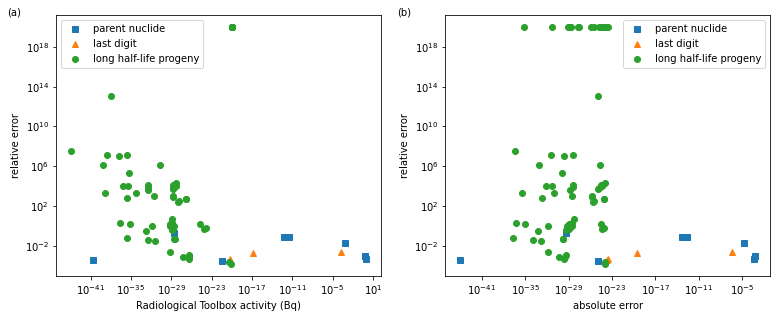

In [10]:
long_hl_progeny_df.loc[long_hl_progeny_df['rt_activity'] == 0.0, 'rt_activity'] = 1e-20
long_hl_progeny_df.loc[long_hl_progeny_df['rel_err'] == np.inf, 'rel_err'] = 1e20

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12.8,4.8))

ax[0].plot(parents_df.rt_activity, parents_df.rel_err, marker='s', linestyle='', label='parent nuclide')
ax[0].plot(last_digit_df.rt_activity, last_digit_df.rel_err, marker='^', linestyle='', label='last digit')
ax[0].plot(long_hl_progeny_df.rt_activity, long_hl_progeny_df.rel_err, marker='o', linestyle='', 
        label='long half-life progeny')
ax[0].set(xlabel='Radiological Toolbox activity (Bq)', ylabel='relative error', xscale='log', yscale='log')
ax[0].legend(loc='upper left')
ax[0].text(-0.15, 1.0, '(a)', transform=ax[0].transAxes)

ax[1].plot(parents_df.abs_err, parents_df.rel_err, marker='s', linestyle='', label='parent nuclide')
ax[1].plot(last_digit_df.abs_err, last_digit_df.rel_err, marker='^', linestyle='', label='last digit')
ax[1].plot(long_hl_progeny_df.abs_err, long_hl_progeny_df.rel_err, marker='o', linestyle='', 
        label='long half-life progeny')
ax[1].set(xlabel='absolute error', ylabel='relative error', xscale='log', yscale='log')
ax[1].legend(loc='upper right')
_ = ax[1].text(-0.15, 1.0, '(b)', transform=ax[1].transAxes)

The graphs demonstrate the different regimes that three groups of discrepancies fall under. The discrepancies starting from activities of parent radionuclides of decay chains (Fr-219, Nb-99, O-14, Ra-220, Sc-42m and Xe-127m) or occuring in the fourth significant digit for some chains (Au-187 and Cs-121m) show relative errors that are bounded (<O(10<sup>-1</sup>) Bq), but activities that occur across the spectrum of activity scales (10<sup>-41</sup> to 10<sup>0</sup> Bq).

Conversely the discrepanies that occur in chains below a long half-life progeny (Am-238, Am-246m, Bk-245, Cf-254 and Pa-234) are restricted to the regime of low radioactivities (<10<sup>-20</sup> Bq) and low absolute errors (<10<sup>-23</sup> Bq). The relative errors are unbounded. These features are characteristic of the numerical precision limit of both codes being crossed.

### Conclusion

The results of decay calculations reported by radioactivedecay and Radiological Toolbox for 50 randomly selected radionuclides from ICRP 107 with randomly chosen decay times are essentially identical. The discrepancies that occur are all within the numerical precision limits of each code, or can be explained by computational stability issues.